In [1]:
import numpy as np
import h5py
import xarray as xr
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.convolution import convolve, Gaussian1DKernel
from specutils import Spectrum
from specutils.manipulation import FluxConservingResampler

In [72]:
ds = xr.open_dataset("D:/Pavlicek, Emma/SDSS1411/SDSS1411_spectra.nc")

wavelength = ds.wavelength.values * u.AA

# Flux and uncertainty arrays with proper units
flux_array = ds.flux_calibrated.values
flux_err_array = ds.flux_calibrated_error.values 

time_seconds = ds.time.values
num_spectra = flux_array.shape[0]

# --- Build Spectrum1D objects with uncertainties ---
spectra = []
for i in range(num_spectra):
    spec = Spectrum(
        spectral_axis=wavelength,
        flux=flux_array[i, :] * u.Unit("erg cm-2 s-1 angstrom-1"),
    )
    spectra.append(spec)

spectrum_obs = spectra[0]

In [73]:
model_B = "D:/Pavlicek, Emma/Flux 3D Models/flux_model_3D_B.h5"

with h5py.File(model_B, 'r') as model_b_h5:
    model_b_flux = model_b_h5['flux'][()]
    model_b_wavelength = model_b_h5['wavelength'][()]
    model_b_gravity = model_b_h5['gravity'][()]
    model_b_temperature = model_b_h5['temperature'][()]

# find the right indices
i_temp = np.where(model_b_temperature == 11500)[0][0]
i_grav = np.where(model_b_gravity == 700)[0][0]  # since your log g values are stored as 800 not 8.0

# slice the flux cube: (gravity, wavelength, temperature)
flux_mod = model_b_flux[i_grav, :, i_temp]
wave_mod = model_b_wavelength  # already 1D, length 6787

spectrum_mod = Spectrum(
    flux=flux_mod * u.Unit("erg cm-2 s-1 angstrom-1"),  # adjust units if different
    spectral_axis=wave_mod * u.AA
)

In [74]:
from astropy.constants import c
from scipy import optimize

logg = 750
teff = 11500
# -------------------------
# Step 1: Extract one model spectrum
# -------------------------
# You already did something like this:
# flux_mod_nu = model_b_flux[i_grav, :, i_temp]   # H_nu in erg/cm^2/s/Hz
# wave_mod_AA = model_b_wavelength                # Angstroms

flux_mod_nu = np.asarray(flux_mod)   # H_nu (erg cm^-2 s^-1 Hz^-1)
wave_mod_AA = np.asarray(wave_mod)   # in Angstroms

# -------------------------
# Step 2: Convert H_nu → H_lambda
# -------------------------
# Units: H_nu [erg cm^-2 s^-1 Hz^-1]
# Relation: H_lambda = H_nu * c / lambda^2
wave_cm = wave_mod_AA * 1e-8                       # convert Angstrom → cm
H_lambda = flux_mod_nu * c.cgs.value / (wave_cm**2)  # erg cm^-2 s^-1 cm^-1

# Convert to per Angstrom: multiply by 1e-8
H_lambda_AA = H_lambda * 1e-8   # erg cm^-2 s^-1 Å^-1

# -------------------------
# Step 3: Surface flux
# -------------------------
F_lambda_AA = 4.0 * np.pi * H_lambda_AA

# -------------------------
# Step 4: Interpolate onto observed wavelength grid
# -------------------------
obs_wave_AA = wavelength.to(u.AA).value
obs_flux = flux_array[0, :]       # your chosen observed spectrum
obs_err  = flux_err_array[0, :]

model_interp = np.interp(obs_wave_AA, wave_mod_AA, F_lambda_AA, left=np.nan, right=np.nan)

# Mask bad values
mask = np.isfinite(obs_flux) & np.isfinite(obs_err) & (obs_err > 0) & np.isfinite(model_interp)
x = obs_wave_AA[mask]
y = obs_flux[mask]
yerr = obs_err[mask]
m = model_interp[mask]

# -------------------------
# Step 5: Fit multiplicative scale S
# -------------------------
# Weighted least squares analytic solution
w = 1.0 / yerr**2
num = np.sum(w * m * y)
den = np.sum(w * m * m)
S_best = num / den
sigma_S = np.sqrt(1.0 / den)

y_model = S_best * m
residuals = y - y_model
chi2 = np.sum((residuals / yerr)**2)
ndof = len(y) - 1
print(f"Best-fit scale S = {S_best:.3e} ± {sigma_S:.3e}")
print(f"Reduced chi2 = {chi2/ndof:.2f} (ndof={ndof})")

# -------------------------
# Step 6: Recover radius (optional)
# -------------------------
# S = (R/D)^2   (since we already applied 4π)
# So R = sqrt(S) * D
distance_pc = None   # set to e.g. 100.0 if known
if distance_pc is not None:
    d_cm = (distance_pc * u.pc).to(u.cm).value
    R_cm = np.sqrt(S_best) * d_cm
    sigma_R = 0.5 * sigma_S / S_best * R_cm
    R_rsun = (R_cm * u.cm).to(u.R_sun).value
    sigma_rsun = (sigma_R * u.cm).to(u.R_sun).value
    print(f"Radius R = {R_rsun:.4f} ± {sigma_rsun:.4f} R_sun")

# -------------------------
# Step 7: Residual spectrum
# -------------------------
full_model = np.full_like(obs_flux, np.nan)
full_resid = np.full_like(obs_flux, np.nan)
full_model[mask] = y_model
full_resid[mask] = residuals



Best-fit scale S = 1.895e-24 ± 7.411e-28
Reduced chi2 = 3.54 (ndof=9770)


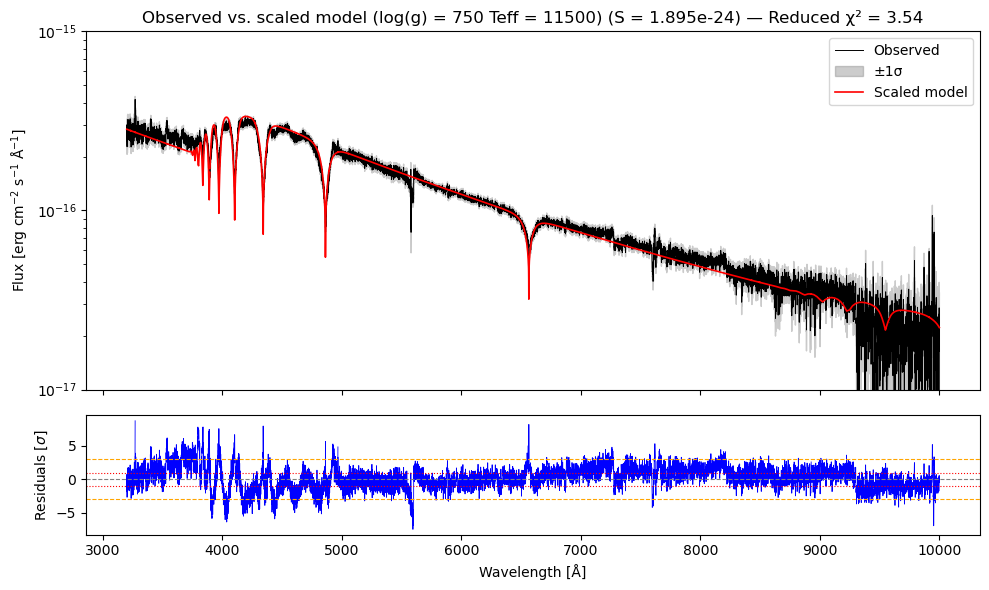

In [75]:
# Normalized residuals (data - model) / error
norm_resid = np.full_like(obs_flux, np.nan)
norm_resid[mask] = residuals / yerr

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[3,1]})

# --- Top panel: spectrum ---
ax1.plot(obs_wave_AA, obs_flux, color='k', lw=0.7, label="Observed")
ax1.fill_between(obs_wave_AA, obs_flux-obs_err, obs_flux+obs_err, 
                 color='gray', alpha=0.4, label="±1σ")
ax1.plot(obs_wave_AA, full_model, color='r', lw=1.2, label="Scaled model")

ax1.set_ylabel("Flux [erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$]")
ax1.set_title(f"Observed vs. scaled model (log(g) = {logg} Teff = {teff}) (S = {S_best:.3e}) — Reduced χ² = {chi2/ndof:.2f}")
ax1.legend(loc="best")
ax1.set_yscale("log")  # optional
ax1.set_ylim([1e-17, 1e-15])

# --- Bottom panel: residuals in σ ---
ax2.plot(obs_wave_AA, norm_resid, color='b', lw=0.6)
ax2.axhline(0, color='gray', lw=0.8, ls="--")
ax2.axhline( 1, color='r', lw=0.8, ls=":")
ax2.axhline(-1, color='r', lw=0.8, ls=":")
ax2.axhline( 3, color='orange', lw=0.8, ls="--")
ax2.axhline(-3, color='orange', lw=0.8, ls="--")

ax2.set_xlabel("Wavelength [Å]")
ax2.set_ylabel(r"Residuals [$\sigma$]")

plt.tight_layout()
plt.show()

Teff        1.150000e+04
S           1.833545e-24
chi2        2.724183e+04
red_chi2    2.788314e+00
Name: 28, dtype: float64


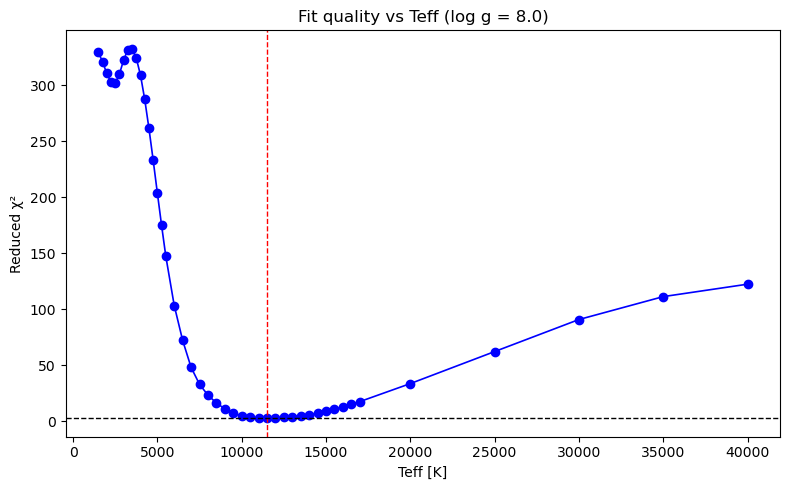

Best-fit Teff = 11500 K (reduced χ² = 2.79)


In [6]:
import pandas as pd

model_B = "D:/Pavlicek, Emma/Flux 3D Models/flux_model_3D_B.h5"

with h5py.File(model_B, 'r') as model_b_h5:
    model_b_flux = model_b_h5['flux'][()]
    model_b_wavelength = model_b_h5['wavelength'][()]
    model_b_gravity = model_b_h5['gravity'][()]
    model_b_temperature = model_b_h5['temperature'][()]

target_logg = 800.0

# The grid stores 8.0 as 800
i_grav = np.where(model_b_gravity == int(target_logg))[0][0]
results = []

for i_temp, Teff in enumerate(model_b_temperature):
    flux_mod_nu = model_b_flux[i_grav, :, i_temp]   # H_nu
    wave_mod_AA = model_b_wavelength

    # Hν → Hλ (per Å)
    wave_cm = wave_mod_AA * 1e-8
    H_lambda = flux_mod_nu * c.cgs.value / (wave_cm**2)
    H_lambda_AA = H_lambda * 1e-8
    F_lambda_AA = 4*np.pi * H_lambda_AA

    # Interpolate to obs grid
    model_interp = np.interp(obs_wave_AA, wave_mod_AA, F_lambda_AA, left=np.nan, right=np.nan)
    mask = np.isfinite(obs_flux) & np.isfinite(obs_err) & (obs_err > 0) & np.isfinite(model_interp)

    y = obs_flux[mask]
    yerr = obs_err[mask]
    m = model_interp[mask]

    # Weighted least squares for scale S
    w = 1.0 / yerr**2
    num = np.sum(w * m * y)
    den = np.sum(w * m * m)
    S_best = num / den
    sigma_S = np.sqrt(1.0 / den)

    y_model = S_best * m
    residuals = y - y_model
    chi2 = np.sum((residuals / yerr)**2)
    ndof = len(y) - 1
    red_chi2 = chi2 / ndof

    results.append({"Teff": Teff, "S": S_best, "chi2": chi2, "red_chi2": red_chi2})

df = pd.DataFrame(results)
best_idx = df["red_chi2"].idxmin()
print(df.loc[best_idx])

# Sort results by Teff for a clean curve
df_sorted = df.sort_values("Teff")

# Plot reduced chi² vs Teff
plt.figure(figsize=(8,5))
plt.plot(df_sorted["Teff"], df_sorted["red_chi2"], marker="o", color="blue", lw=1.2)

# Mark the best fit
best_idx = df_sorted["red_chi2"].idxmin()
best_Teff = df_sorted.loc[best_idx, "Teff"]
best_redchi2 = df_sorted.loc[best_idx, "red_chi2"]
plt.axvline(best_Teff, color="red", ls="--", lw=1)
plt.axhline(best_redchi2, color="black", ls="--", lw=1)

plt.xlabel("Teff [K]")
plt.ylabel("Reduced χ²")
plt.title(f"Fit quality vs Teff (log g = {model_b_gravity[i_grav]/100:.1f})")
plt.tight_layout()
plt.show()

print(f"Best-fit Teff = {best_Teff:.0f} K (reduced χ² = {best_redchi2:.2f})")


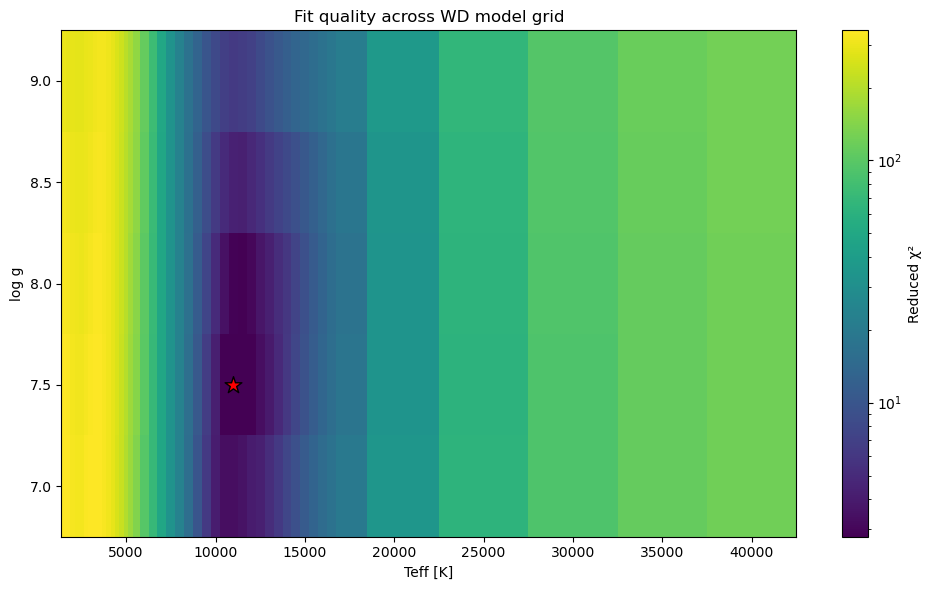

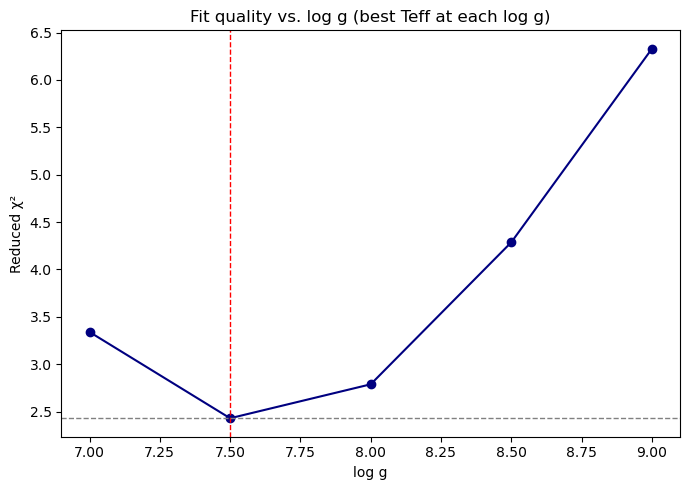

Best-fit log g = 7.50, reduced χ² = 2.43


In [69]:
import matplotlib.colors as mcolors
import pandas as pd 

model_B = "D:/Pavlicek, Emma/Flux 3D Models/flux_model_3D_B.h5"

with h5py.File(model_B, 'r') as model_b_h5:
    model_b_flux = model_b_h5['flux'][()]
    model_b_wavelength = model_b_h5['wavelength'][()]
    model_b_gravity = model_b_h5['gravity'][()]
    model_b_temperature = model_b_h5['temperature'][()]

results = []

for i_grav, gval in enumerate(model_b_gravity):
    logg = gval / 100.0   # convert 800 → 8.0
    for i_temp, Teff in enumerate(model_b_temperature):
        flux_mod_nu = model_b_flux[i_grav, :, i_temp]

        # --- Hν → Hλ per Å ---
        wave_cm = model_b_wavelength * 1e-8
        H_lambda = flux_mod_nu * c.cgs.value / (wave_cm**2)
        H_lambda_AA = H_lambda * 1e-8
        F_lambda_AA = 4*np.pi * H_lambda_AA

        # --- interpolate to obs grid ---
        model_interp = np.interp(obs_wave_AA, model_b_wavelength, F_lambda_AA,
                                 left=np.nan, right=np.nan)
        mask = np.isfinite(obs_flux) & np.isfinite(obs_err) & (obs_err > 0) & np.isfinite(model_interp)

        y = obs_flux[mask]
        yerr = obs_err[mask]
        m = model_interp[mask]

        # --- weighted least squares scaling ---
        w = 1.0 / yerr**2
        num = np.sum(w * m * y)
        den = np.sum(w * m * m)
        S_best = num / den
        sigma_S = np.sqrt(1.0 / den)

        residuals = y - S_best * m
        chi2 = np.sum((residuals / yerr)**2)
        ndof = len(y) - 1
        red_chi2 = chi2 / ndof

        results.append({
            "logg": logg,
            "Teff": Teff,
            "S": S_best,
            "red_chi2": red_chi2
        })

df = pd.DataFrame(results)

pivot = df.pivot_table(index="logg", columns="Teff", values="red_chi2")
# ensure pivot is sorted in ascending Teff and logg
pivot = pivot.sort_index(ascending=True)         # rows -> logg increasing
pivot = pivot.sort_index(axis=1, ascending=True) # columns -> Teff increasing

Teff = pivot.columns.values   # x-axis
logg = pivot.index.values     # y-axis
Teff_grid, logg_grid = np.meshgrid(Teff, logg)

Z = pivot.values  # shape (n_logg, n_Teff)

 
vmin = np.nanpercentile(Z[Z>0], 1)
vmax = np.nanpercentile(Z[Z>0], 99)
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)



fig, ax = plt.subplots(figsize=(10,6))
pcm = ax.pcolormesh(Teff_grid, logg_grid, Z, shading='auto', cmap='viridis', norm=norm)
cb = fig.colorbar(pcm, ax=ax)
cb.set_label("Reduced χ²")

# mark best-fit
best_idx = df['red_chi2'].idxmin()
best_Teff = df.loc[best_idx,'Teff']
best_logg  = df.loc[best_idx,'logg']
ax.scatter(best_Teff, best_logg, s=160, marker='*', color='red', edgecolor='k', zorder=10)

ax.set_xlabel("Teff [K]")
ax.set_ylabel("log g")
ax.set_title("Fit quality across WD model grid")
plt.tight_layout()
plt.show()

# For each log g, get the best reduced χ²
df_min_g = df.loc[df.groupby("logg")["red_chi2"].idxmin()]

plt.figure(figsize=(7,5))
plt.plot(df_min_g["logg"], df_min_g["red_chi2"], marker="o", color="navy")

# Mark the overall best-fit log g
best_idx = df_min_g["red_chi2"].idxmin()
best_logg = df_min_g.loc[best_idx, "logg"]
best_redchi2 = df_min_g.loc[best_idx, "red_chi2"]
plt.axvline(best_logg, color="red", ls="--", lw=1)
plt.axhline(best_redchi2, color="gray", ls="--", lw=1)

plt.xlabel("log g")
plt.ylabel("Reduced χ²")
plt.title("Fit quality vs. log g (best Teff at each log g)")
plt.tight_layout()
plt.show()

print(f"Best-fit log g = {best_logg:.2f}, reduced χ² = {best_redchi2:.2f}")



Optimizer success: True CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Best-fit: Teff = 11226.9 K, logg = 7.6194, redχ² = 2.360
S_best = 1.952e-24 ± 7.625e-28
1σ errors: ΔTeff = +1340/-953, Δlogg = +0.628/-0.610


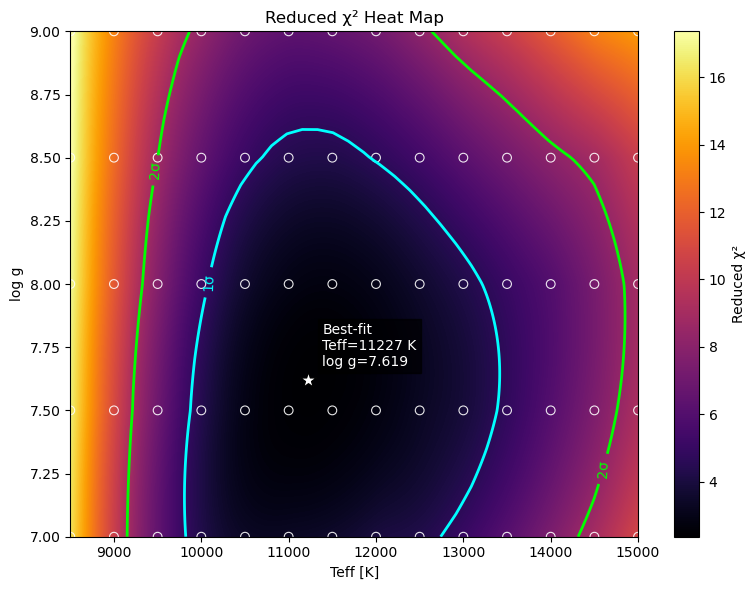

In [ ]:
#try interpolating for a model fit
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize, minimize_scalar, approx_fprime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
from numpy.linalg import inv
import matplotlib.transforms as transforms

# ==============================================================
# --- 1. Prepare grids and interpolate models onto obs wavelengths
# ==============================================================

logg_grid = np.array(model_b_gravity) / 100.0   # e.g. [7.0, 7.5, 8.0]
Teff_grid = np.array(model_b_temperature)       # e.g. [11000, 12000, 13000, ...]
n_logg = len(logg_grid)
n_Teff = len(Teff_grid)
n_wave_obs = len(obs_wave_AA)

M_spec = np.empty((n_logg, n_Teff, n_wave_obs), dtype=float)

for i_g in range(n_logg):
    for i_t in range(n_Teff):
        flux_mod_nu = model_b_flux[i_g, :, i_t]
        wave_cm = model_b_wavelength * 1e-8
        H_lambda = flux_mod_nu * c.cgs.value / (wave_cm**2)
        H_lambda_AA = H_lambda * 1e-8
        F_lambda_AA = 4 * np.pi * H_lambda_AA
        M_spec[i_g, i_t, :] = np.interp(
            obs_wave_AA, model_b_wavelength, F_lambda_AA, left=np.nan, right=np.nan
        )

# ==============================================================
# --- 2. Clean data
# ==============================================================

valid = np.isfinite(obs_flux) & np.isfinite(obs_err) & (obs_err > 0)
if not valid.all():
    valid_idx = np.where(valid)[0]
    obs_wave_eff = obs_wave_AA[valid_idx]
    obs_flux_eff = obs_flux[valid_idx]
    obs_err_eff = obs_err[valid_idx]
    M_spec = M_spec[:, :, valid_idx]
else:
    obs_wave_eff = obs_wave_AA
    obs_flux_eff = obs_flux
    obs_err_eff = obs_err

# ==============================================================
# --- 3. Build interpolator
# ==============================================================

interpolator = RegularGridInterpolator(
    (logg_grid, Teff_grid), M_spec, bounds_error=True, fill_value=None
)

# ==============================================================
# --- 4. Chi-squared function
# ==============================================================

def chi2_for_params(x):
    Teff_val, logg_val = float(x[0]), float(x[1])

    try:
        model_vec = interpolator((logg_val, Teff_val))
    except Exception:
        return 1e30

    good = np.isfinite(model_vec) & np.isfinite(obs_flux_eff) & np.isfinite(obs_err_eff)
    if good.sum() < 10:
        return 1e30

    y = obs_flux_eff[good]
    yerr = obs_err_eff[good]
    m = model_vec[good]

    w = 1.0 / (yerr**2)
    num = np.sum(w * m * y)
    den = np.sum(w * m * m)
    if den <= 0:
        return 1e30
    S_best = num / den

    residuals = y - S_best * m
    chi2 = np.sum((residuals / yerr) ** 2)
    ndof = good.sum() - 1
    redchi2 = chi2 / max(1, ndof)
    return redchi2

# ==============================================================
# --- 5. Optimization
# ==============================================================

# Make sure Teff_z/logg_z exist and are non-empty
Teff_z = Teff_grid
logg_z = logg_grid

x0 = np.array([13000, 7.5])
bounds = [(Teff_z.min(), Teff_z.max()), (logg_z.min(), logg_z.max())]

res = minimize(
    chi2_for_params, x0, method="L-BFGS-B", bounds=bounds,
    options={'ftol': 1e-8, 'gtol': 1e-6, 'maxiter': 200}
)

Teff_best_cont, logg_best_cont = res.x
redchi2_best = res.fun

print("Optimizer success:", res.success, res.message)
print(f"Best-fit: Teff = {Teff_best_cont:.1f} K, logg = {logg_best_cont:.4f}, redχ² = {redchi2_best:.3f}")

# ==============================================================
# --- 6. Compute scaling factor S
# ==============================================================

model_best_vec = interpolator((logg_best_cont, Teff_best_cont))
good = np.isfinite(model_best_vec) & np.isfinite(obs_flux_eff) & np.isfinite(obs_err_eff)
w = 1.0 / obs_err_eff[good] ** 2
S_best_local = np.sum(w * model_best_vec[good] * obs_flux_eff[good]) / np.sum(w * model_best_vec[good] ** 2)
sigma_S = np.sqrt(1.0 / np.sum(w * model_best_vec[good] ** 2))
print(f"S_best = {S_best_local:.3e} ± {sigma_S:.3e}")

# ==============================================================
# --- 7. Build reduced χ² map
# ==============================================================

Teff_vals = np.linspace(Teff_grid.min(), Teff_grid.max(), 300)
logg_vals = np.linspace(logg_grid.min(), logg_grid.max(), 200)
Chi = np.empty((len(logg_vals), len(Teff_vals)))

for i, lg in enumerate(logg_vals):
    for j, te in enumerate(Teff_vals):
        try:
            model_vec = interpolator((lg, te))
        except:
            Chi[i, j] = np.nan
            continue
        good = np.isfinite(model_vec) & np.isfinite(obs_flux_eff) & np.isfinite(obs_err_eff)
        if good.sum() < 10:
            Chi[i, j] = np.nan
            continue

        y, yerr, m = obs_flux_eff[good], obs_err_eff[good], model_vec[good]
        w = 1.0 / (yerr**2)
        num = np.sum(w * m * y)
        den = np.sum(w * m * m)
        if den <= 0:
            Chi[i, j] = np.nan
            continue
        S_best = num / den
        residuals = y - S_best * m
        chi2 = np.sum((residuals / yerr)**2)
        ndof = good.sum() - 1
        Chi[i, j] = chi2 / max(1, ndof)

# ==============================================================
# --- 8. Compute ±1σ intervals and 2D ellipse
# ==============================================================

chi2_min = redchi2_best

def chi2_vs_Teff(teff_val): return chi2_for_params([teff_val, logg_best_cont])
def chi2_vs_logg(logg_val): return chi2_for_params([Teff_best_cont, logg_val])

# Teff 1σ
res_lo = minimize_scalar(lambda t: abs(chi2_vs_Teff(t) - (chi2_min + 1)),
                         bounds=(Teff_grid.min(), Teff_best_cont), method='bounded')
res_hi = minimize_scalar(lambda t: abs(chi2_vs_Teff(t) - (chi2_min + 1)),
                         bounds=(Teff_best_cont, Teff_grid.max()), method='bounded')
Teff_err_minus = Teff_best_cont - res_lo.x
Teff_err_plus  = res_hi.x - Teff_best_cont

# log g 1σ
res_lo = minimize_scalar(lambda g: abs(chi2_vs_logg(g) - (chi2_min + 1)),
                         bounds=(logg_grid.min(), logg_best_cont), method='bounded')
res_hi = minimize_scalar(lambda g: abs(chi2_vs_logg(g) - (chi2_min + 1)),
                         bounds=(logg_best_cont, logg_grid.max()), method='bounded')
logg_err_minus = logg_best_cont - res_lo.x
logg_err_plus  = res_hi.x - logg_best_cont

print(f"1σ errors: ΔTeff = +{Teff_err_plus:.0f}/-{Teff_err_minus:.0f}, "
      f"Δlogg = +{logg_err_plus:.3f}/-{logg_err_minus:.3f}")

# Hessian for 2D covariance ellipse
eps = np.sqrt(np.finfo(float).eps)
x_best = np.array([Teff_best_cont, logg_best_cont])

def grad(x): return approx_fprime(x, chi2_for_params, [eps, eps])
def hessian(f, x):
    g0 = grad(x)
    n = len(x)
    H = np.zeros((n, n))
    for i in range(n):
        x1 = np.array(x, copy=True)
        x1[i] += eps
        g1 = grad(x1)
        H[:, i] = (g1 - g0) / eps
    return H

H = hessian(chi2_for_params, x_best)
cov = inv(H)
vals, vecs = np.linalg.eigh(cov)
order = vals.argsort()[::-1]
vals, vecs = vals[order], vecs[:, order]
theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
width, height = 2 * np.sqrt(2.30 * vals)  # Δχ²=2.30 for 68% joint conf.

# ==============================================================
# --- 9. Plotting
# ==============================================================
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# --- Compute chi² grid as before ---
Teff_vals = np.linspace(5000, 40000, 200)
logg_vals = np.linspace(7.0, 9.0, 150)
Chi = np.empty((len(logg_vals), len(Teff_vals)))

for i, lg in enumerate(logg_vals):
    for j, te in enumerate(Teff_vals):
        try:
            model_vec = interpolator((lg, te))
        except Exception:
            Chi[i, j] = np.nan
            continue
        good = np.isfinite(model_vec) & np.isfinite(obs_flux_eff) & np.isfinite(obs_err_eff)
        if good.sum() < 10:
            Chi[i, j] = np.nan
            continue
        y, yerr, m = obs_flux_eff[good], obs_err_eff[good], model_vec[good]
        w = 1 / yerr**2
        num = np.sum(w * m * y)
        den = np.sum(w * m * m)
        if den <= 0:
            Chi[i, j] = np.nan
            continue
        S_best = num / den
        chi2 = np.sum(((y - S_best * m) / yerr) ** 2)
        ndof = good.sum() - 1
        Chi[i, j] = chi2 / max(1, ndof)

chi2_min = np.nanmin(Chi)
delta_chi2 = Chi - chi2_min

# --- Plot heatmap ---
fig, ax = plt.subplots(figsize=(8,6))

vmin, vmax = chi2_min, chi2_min + 15
im = ax.imshow(
    Chi, origin='lower', aspect='auto',
    extent=[Teff_vals.min(), Teff_vals.max(), logg_vals.min(), logg_vals.max()],
    cmap='inferno', vmin=vmin, vmax=vmax,
    interpolation='bicubic'
)
cb = fig.colorbar(im, ax=ax, label='Reduced χ²')

# --- Add 1σ and 2σ contours ---
contours = ax.contour(
    Teff_vals, logg_vals, delta_chi2,
    levels=[2.30, 6.17], colors=['cyan', 'lime'], linewidths=2
)
ax.clabel(contours, fmt={2.30: "1σ", 6.17: "2σ"}, colors=['cyan', 'lime'])

# Overlay markers at the original model grid points (true grid, not interpolated)
Teff_mesh, logg_mesh = np.meshgrid(Teff_grid, logg_grid)
ax.scatter(
    Teff_mesh, logg_mesh,
    s=40,
    facecolors='none',
    edgecolors='white',
    linewidths=0.8,
    alpha=0.9,
    label='Model grid points'
)


# --- Mark the best fit ---
ax.scatter(Teff_best_cont, logg_best_cont, s=150, marker='*',
           color='white', edgecolor='k', zorder=10)
ax.annotate(f"Best-fit\nTeff={Teff_best_cont:.0f} K\nlog g={logg_best_cont:.3f}",
            xy=(Teff_best_cont, logg_best_cont), xytext=(10, 10),
            textcoords="offset points", color="white",
            bbox=dict(facecolor="black", alpha=0.7, pad=3))

ax.set_xlim(8500, 15000)
ax.set_ylim(7.0, 9.0)
ax.set_xlabel("Teff [K]")
ax.set_ylabel("log g")
ax.set_title("Reduced χ² Heat Map")
plt.tight_layout()
plt.show()



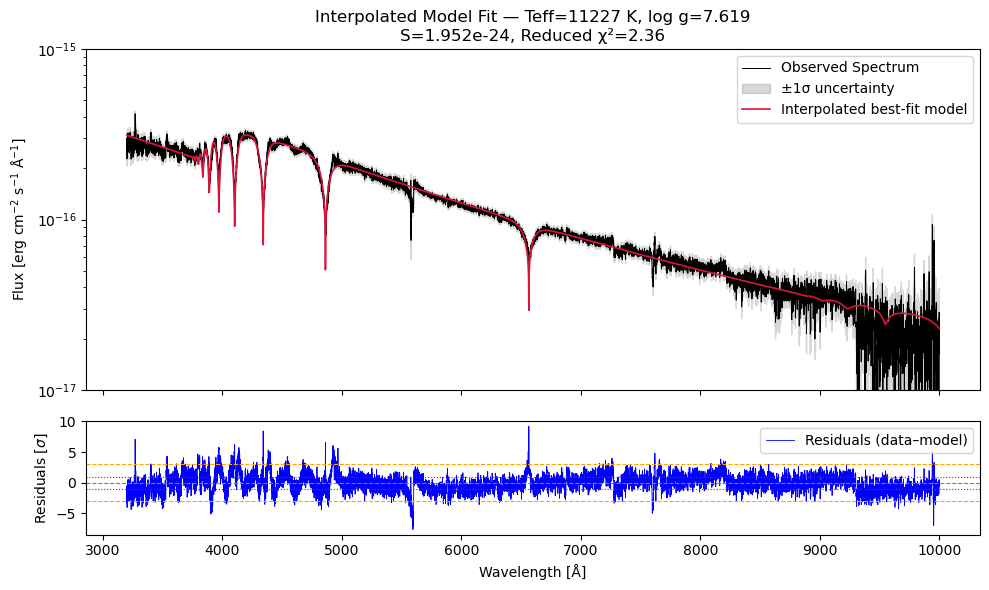

In [67]:
# ==============================================================
# --- Build interpolated best-fit model and residuals
# ==============================================================

# Get interpolated model spectrum at best-fit (continuous) parameters
model_interp_vec = interpolator((logg_best_cont, Teff_best_cont))

# Mask good pixels
good = np.isfinite(model_interp_vec) & np.isfinite(obs_flux_eff) & np.isfinite(obs_err_eff)
y = obs_flux_eff[good]
yerr = obs_err_eff[good]
m = model_interp_vec[good]

# Compute optimal scaling S for the interpolated model
w = 1.0 / yerr**2
S_best_interp = np.sum(w * m * y) / np.sum(w * m * m)
residuals = y - S_best_interp * m

# Map back to full wavelength array for plotting (fill NaN elsewhere)
full_model = np.full_like(obs_flux_eff, np.nan)
full_model[good] = S_best_interp * m

# Normalized residuals
norm_resid = np.full_like(obs_flux_eff, np.nan)
norm_resid[good] = residuals / yerr

# ==============================================================
# --- Plot observed vs interpolated model + residuals
# ==============================================================

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6),
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# --- Top panel: Spectrum ---
ax1.plot(obs_wave_eff, obs_flux_eff, color='k', lw=0.7, label="Observed Spectrum")
ax1.fill_between(
    obs_wave_eff,
    obs_flux_eff - obs_err_eff,
    obs_flux_eff + obs_err_eff,
    color='gray', alpha=0.3, label="±1σ uncertainty"
)

ax1.plot(obs_wave_eff, full_model, color='crimson', lw=1.2, label="Interpolated best-fit model")

ax1.set_ylabel("Flux [erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$]")
ax1.set_title(
    f"Interpolated Model Fit — Teff={Teff_best_cont:.0f} K, log g={logg_best_cont:.3f}\n"
    f"S={S_best_interp:.3e}, Reduced χ²={redchi2_best:.2f}"
)
ax1.legend(loc="best")
ax1.set_yscale("log")  # optional
ax1.set_ylim([1e-17, 1e-15])

# --- Bottom panel: residuals ---
ax2.plot(obs_wave_eff, norm_resid, color='b', lw=0.6, label="Residuals (data–model)")
ax2.axhline(0, color='gray', lw=0.8, ls="--")
ax2.axhline(1, color='r', lw=0.8, ls=":")
ax2.axhline(-1, color='r', lw=0.8, ls=":")
ax2.axhline(3, color='orange', lw=0.8, ls="--")
ax2.axhline(-3, color='orange', lw=0.8, ls="--")

ax2.set_xlabel("Wavelength [Å]")
ax2.set_ylabel(r"Residuals [$\sigma$]")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [97]:
# Quick approximate uncertainties from Hessian (fast, optimistic)
try:
    hess_inv = res.hess_inv.todense()   # L-BFGS-B returns an L-BFGS inverse-H approximation
    cov_approx = np.array(hess_inv, copy=True)
    # scale by reduced chi2 if >1
    if np.isfinite(redchi2_best) and redchi2_best > 1.0:
        cov_approx = cov_approx * redchi2_best
    sigma_Teff_h = np.sqrt(cov_approx[0,0])
    sigma_logg_h = np.sqrt(cov_approx[1,1])
    print(f"Hessian approx: Teff ±{sigma_Teff_h:.1f} K, logg ±{sigma_logg_h:.4f}")
except Exception as e:
    print("Hessian extraction failed:", e)


Hessian approx: Teff ±1206.7 K, logg ±0.6876


C:\Users\ecpav\AppData\Local\Temp\ipykernel_25616\3814598837.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(
C:\Users\ecpav\AppData\Local\Temp\ipykernel_25616\3814598837.py:98: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(


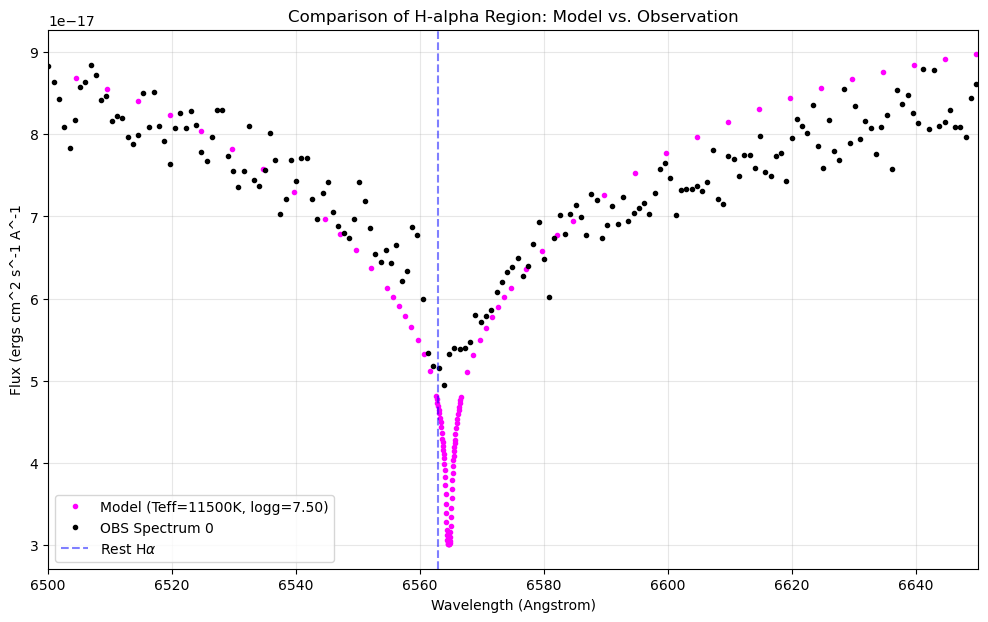

Model Flux Range: 3.01e-17 to 8.97e-17
Observed Flux Range: 4.94e-17 to 8.85e-17

--- VISUAL ASSESSMENT ---
1. Compare the resolution/smoothness of the Red Model line to the Gray Data points.
2. Is the Model smooth enough to be insufficient for a precise redshift/line-profile fit?
If the model appears significantly lower resolution than the data, you need a higher-resolution model grid.


In [ ]:
model_B = "D:/Pavlicek, Emma/Flux 3D Models/flux_model_3D_B.h5"
with h5py.File(model_B, 'r') as model_b_h5:
    model_b_flux = model_b_h5['flux'][()]
    model_b_wavelength = model_b_h5['wavelength'][()]
    model_b_gravity = model_b_h5['gravity'][()]
    model_b_temperature = model_b_h5['temperature'][()]

i_temp = np.where(model_b_temperature == 11500)[0][0]
i_grav = np.where(model_b_gravity == 750)[0][0] 

flux_mod = model_b_flux[i_grav, :, i_temp]
wave_mod = model_b_wavelength 

spectrum_mod = Spectrum(
    flux=flux_mod * u.Unit("erg cm-2 s-1 angstrom-1"),
    spectral_axis=wave_mod * u.AA
    )

ds = xr.open_dataset("D:/Pavlicek, Emma/SDSS1411/SDSS1411_spectra.nc")

wavelength = ds.wavelength.values * u.AA
flux_array = ds.flux_calibrated.values
flux_err_array = ds.flux_calibrated_error.values 
time_seconds = ds.time.values
num_spectra = flux_array.shape[0]

# Build Spectrum objects WITH UNCERTAINTIES (FIXED)
spectra_obs = []
for i in range(num_spectra):
    # The uncertainty must be wrapped in a StdDevUncertainty object
    uncertainty = StdDevUncertainty(flux_err_array[i, :])
    
    spec = Spectrum(
        spectral_axis=wavelength,
        flux=flux_array[i, :] * u.Unit("erg cm-2 s-1 angstrom-1"),
        uncertainty=uncertainty
    )
    spectra_obs.append(spec)

# Assuming spectrum_mod is already defined as in the prompt
# using T_eff=11500 K and log(g)=7.50
lambda_min = 6500 * u.AA
lambda_max = 6650 * u.AA

# =========================================================
# 1. TRIMMING THE MODEL SPECTRUM (Teff=11500K, logg=7.50)
# =========================================================

# Extract the base numpy array from the Astropy Quantity for comparison
wave_mod_value = spectrum_mod.spectral_axis.to(u.AA).value

# Create a boolean mask where the wavelength is within the desired range
model_mask = (wave_mod_value >= lambda_min.value) & (wave_mod_value <= lambda_max.value)

# Apply the mask to all relevant arrays
wave_mod_cut = wave_mod_value[model_mask]
flux_mod_cut = spectrum_mod.flux.value[model_mask]

SCALE_S = 1.7e-12
flux_mod_scaled = flux_mod_cut * SCALE_S

# =========================================================
# 2. TRIMMING THE OBSERVED SPECTRUM (Time Step 0)
# =========================================================

# Pick the first observed spectrum for comparison (Time step 0)
obs_spec_to_plot = spectra_obs[0]

# Extract the base numpy array from the Astropy Quantity for comparison
wave_obs_value = obs_spec_to_plot.spectral_axis.to(u.AA).value

# Create the boolean mask (we reuse the same limits)
obs_mask = (wave_obs_value >= lambda_min.value) & (wave_obs_value <= lambda_max.value)

# Apply the mask to all relevant arrays
wave_obs_cut = wave_obs_value[obs_mask]
flux_obs_cut = obs_spec_to_plot.flux.value[obs_mask]



# =========================================================
# 3. PLOTTING THE COMPARISON
# =========================================================

plt.figure(figsize=(12, 7))


# Plot Model Spectrum
plt.plot(
    wave_mod_cut,
    flux_mod_scaled,
    'r.',
    color='magenta',
    linewidth=2,
    label='Model (Teff=11500K, logg=7.50)'
)

plt.plot(
    wave_obs_cut,
    flux_obs_cut,
    'r.',
    color='black',
    linewidth=2,
    label='OBS Spectrum 0'
)


# Highlight the rest wavelength of H-alpha
H_alpha_rest = 6562.8  # Angstrom
plt.axvline(x=H_alpha_rest, color='blue', linestyle='--', alpha=0.5, label=r'Rest $\text{H}\alpha$')

plt.title('Comparison of H-alpha Region: Model vs. Observation')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (ergs cm^2 s^-1 A^-1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(6500, 6650) # Keep these limits for clean visualization
plt.show()

print(f"Model Flux Range: {flux_mod_scaled.min():.2e} to {flux_mod_scaled.max():.2e}")
print(f"Observed Flux Range: {flux_obs_cut.min():.2e} to {flux_obs_cut.max():.2e}")

# --- CRITICAL VISUAL ASSESSMENT ---
print("\n--- VISUAL ASSESSMENT ---")
print("1. Compare the resolution/smoothness of the Red Model line to the Gray Data points.")
print("2. Is the Model smooth enough to be insufficient for a precise redshift/line-profile fit?")
print("If the model appears significantly lower resolution than the data, you need a higher-resolution model grid.")